In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from numpy import newaxis
import random as rand

import warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings
from sklearn.metrics import mean_squared_error as mse

In [ ]:
## Method for moving averages

# if you want to change the number of values you want then change this line: closing_prices = df.iloc[0:30].values
# say you want more data points: closing_prices = df.iloc[0:50].values
# if you want a larger interval to average ie price(t) + price(delta + t) / interval --> then change the interval
# interval is just the days you are dividing by the changes in price

# parameters you might want to put in
def movingaverage(number_of_days, stock_list):
    
    moving_avg = []
    interval = 5
    
    for stock in stock_list:
        print(stock)
        df = pd.read_csv("stock_csv_avg_test/" + stock + '.csv') 
        df= df[['4. close']]
        closing_prices = df.iloc[0:30].values
        len_prices = len(closing_prices)

        for i in range(len_prices):  
            if i==(len_prices-interval-1):
                break
            
            sum_prices = 0 
            for j in range(interval): 
                print(closing_prices[i+j])
                sum_prices += closing_prices[i+j]

                
            moving_avg.append(sum_prices/interval) 
            
            #you dont need this, it is just a visual
            print('sum:',sum_prices)
            #print('\n') 
            print('moving avg:',moving_avg)
            print('\n')
            
        #clearing moving averages list - you might not need this
        moving_avg.clear()

In [32]:
def convertData(leng, stock):
    df = pd.DataFrame()
    raw_seq = pd.read_csv("../Stock_CSV/" +stock + ".csv")
    raw_seq = raw_seq.set_index('date')
    raw_seq = raw_seq.iloc[::-1]
    seq = np.array(raw_seq['4. close'])
    df['pred'] = seq[30:]
    for i in range(0,leng):
        df['val'+str(i)] = seq[i:len(seq)-30+i]
    return df

In [33]:
dffb = convertData(30,'FB')

In [34]:
dffb

,pred,val0,val1,val2,val3,val4,val5,val6,val7,val8,...,val20,val21,val22,val23,val24,val25,val26,val27,val28,val29
0,30.771,38.2318,34.03,31.00,32.00,33.03,31.91,28.84,28.190,29.600,...,31.410,31.911,31.60,31.84,33.05,32.060,33.100,32.230,31.360,31.095
1,31.200,34.0300,31.00,32.00,33.03,31.91,28.84,28.19,29.600,27.720,...,31.911,31.600,31.84,33.05,32.06,33.100,32.230,31.360,31.095,30.771
2,31.470,31.0000,32.00,33.03,31.91,28.84,28.19,29.60,27.720,26.900,...,31.600,31.840,33.05,32.06,33.10,32.230,31.360,31.095,30.771,31.200
3,31.730,32.0000,33.03,31.91,28.84,28.19,29.60,27.72,26.900,25.869,...,31.840,33.050,32.06,33.10,32.23,31.360,31.095,30.771,31.200,31.470
4,32.170,33.0300,31.91,28.84,28.19,29.60,27.72,26.90,25.869,26.810,...,33.050,32.060,33.10,32.23,31.36,31.095,30.771,31.200,31.470,31.730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942,148.100,212.3300,213.06,207.19,210.76,213.14,214.18,217.80,217.490,214.580,...,169.500,178.190,170.24,154.47,170.28,146.010,149.420,146.960,153.130,149.730
1943,160.980,213.0600,207.19,210.76,213.14,214.18,217.80,217.49,214.580,210.180,...,178.190,170.240,154.47,170.28,146.01,149.420,146.960,153.130,149.730,148.100
1944,156.210,207.1900,210.76,213.14,214.18,217.80,217.49,214.58,210.180,200.720,...,170.240,154.470,170.28,146.01,149.42,146.960,153.130,149.730,148.100,160.980
1945,163.340,210.7600,213.14,214.18,217.80,217.49,214.58,210.18,200.720,196.770,...,154.470,170.280,146.01,149.42,146.96,153.130,149.730,148.100,160.980,156.210


In [2]:
def normalise_windows(window_data):
    normalised_data = []
    normalised_window_0 = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
        normalised_window_0.append(window[0])
    return (normalised_data,normalised_window_0)
#divides each value 

In [3]:
def reverse_normalise(y, reverse, start_val):
    normalised_data = []
    i = start_val
    for valuey in y:
        value = ((float(valuey)+1) * float(reverse[i])) 
        normalised_data.append(value)
        i = i+1
    return normalised_data

In [4]:
def set_data(stock, seq_len):
        raw_seq = pd.read_csv("../Stock_CSV/"+ stock +'.csv')['4. close']
        sequence_length = seq_len + 1
        seq = [ele for ele in reversed(raw_seq)] 
        seq = np.array(seq)
        result = []
        for index in range(len(seq) - sequence_length ):
            result.append(seq[index: index + sequence_length])
        
        result, result_reverse = normalise_windows(result)
        
        result = np.array(result)

        row = round(0.95 * len(result))
        train = result[:int(row), :]
        #np.random.shuffle(train)
        x_train = train[:, :-1]
        y_train = train[:, -1]
        x_test = result[int(row):, :-1]
        y_test = result[int(row):, -1]

        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

        result.shape
        return (x_train, x_test, y_train, y_test, result_reverse, row)
    #except:
        #print("file" + stock + ".csv not found")


In [5]:
def set_data1(stock, seq_len):
        raw_seq = pd.read_csv("../Stock_CSV/"+ stock +'.csv')['4. close']
        sequence_length = seq_len + 1
        seq = [ele for ele in reversed(raw_seq)] 
        seq = np.array(seq)
        result = []
        for index in range(len(seq) - sequence_length ):
            result.append(seq[index: index + sequence_length])
        
        result, result_reverse = normalise_windows(result)
        
        result = np.array(result)

        row = round(0.4 * len(result))
        train = result[:int(row), :]
        #np.random.shuffle(train)
        x_train = train[:, :-1]
        y_train = train[:, -1]
        x_test = result[int(row):, :-1]
        y_test = result[int(row):, -1]

        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

        result.shape
        return (x_train, x_test, y_train, y_test, result_reverse, row)
    #except:
        #print("file" + stock + ".csv not found")


In [6]:
def set_stock_list():
    arr = []
    with open("../NASDAQ.txt", "r") as filestream:
        for line in filestream:
            currentline = line.split(',')
            arr.append(currentline)
    newarr = np.array(arr[0])
    return newarr

In [7]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

In [8]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted


In [9]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs


In [10]:
def plot_results_multiple(predicted_data, true_data, prediction_len, stock):
    fig = plt.figure(facecolor='white',figsize = (14,4))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data)
        plt.title(stock + " Closing Stock Price")
        plt.legend()
    plt.show()

In [11]:
from keras.models import load_model
#model.save('stock_NN.h5')

In [12]:
def accuracy(y_true, y_pred):
    prev_true = y_true[0]
    prev_pred = y_pred[0]
    correct = 0
    incorrect = 0
    for i in range(1,len(y_pred)):
        if prev_true < y_true[i] and prev_true < y_pred[i]:
            correct = correct+1
        elif prev_true > y_true[i] and prev_true > y_pred[i]:
            correct = correct+1
        else:
            incorrect = incorrect+1
        prev_true = y_true[i]
        prev_pred = y_pred[i]        
    return (correct, incorrect)

In [13]:
def n_day_accuracy(days, y_true, pred):
    y_pred = []
    for nums in pred:
        y_pred.append(nums[-1])
    prev_true = y_true[0]
    correct = 0
    incorrect = 0
    j = days-1
    for i in range(0, len(y_pred)):
        if prev_true < y_true[j] and prev_true < y_pred[i]:
            correct = correct+1
        elif prev_true > y_true[j] and prev_true > y_pred[i]:
            correct = correct+1
        else:
            incorrect = incorrect+1
        j = j+1
        if j+1 > len(y_true)-1:
            break
        prev_true = y_true[j+1]
        j = j + days
        if j > len(y_true):
            break
    return (correct, incorrect)
    

In [14]:
def build_model(shape):
    #act = keras.layers.advanced_activations.PReLU(init='zero', weights=None)
    # The LSTM architecture
    regressor = Sequential()
    # First LSTM layer with Dropout regularisation
    regressor.add(LSTM(units=50, return_sequences=True, input_shape=(shape,1)))
    regressor.add(Dropout(0.4))
    # Second LSTM layer
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.4))
    # Third LSTM layer
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.5))
    #model.add(Activation('sigmoid'))
    # Fourth LSTM layer 
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.5))
    # The output layer
   
    regressor.add(Dense(units=1))

    # Compiling the RNN
    regressor.compile(optimizer='adam', loss='mean_squared_error')
    return regressor

In [19]:
seq_length = 200

In [20]:
model = build_model(seq_length)

In [ ]:
model = load_model('stock_nn_1epochs_200best2.h5')

In [115]:
stock_list1 = ['AMZN', 'MSFT', 'GOOGL', 'CTSH', 'VIVO', 'IBM', 'CSCO', 'NVDA','AMD', 'NKTR', 'WMT']

In [ ]:
stock_list = ['AMZN', 'MSFT', 'GOOGL', 'CTSH', 'VIVO', 'IBM', 'CSCO', 'NVDA','AMD', 'NKTR', 'WMT','AAPL','ABT','ACN','ADBE','AGN','AIG','ALL','AMGN','AXP','BA','BAC','BIIB','BK','BKNG',
                'BLK','BMY','BRK.B','C','CAT','CL','CMCSA','COF','COST','CVS','CVX','DD','DHR','DIS',
                'DUK','EMR','EXC','F','FB','FDX','GD','GE','GILD','GM','GOOG','GS','HD','HON',
                'INTC','JNJ','JPM','KHC','KMI','KO','LLY','LMT','LOW','MA','MCD','MDLZ','MDT','MET','MMM','MO','MRK',
                'MS','NEE','NFLX','NKE','ORCL','OXY','PEP','PFE','PG','PM','PYPL','QCOM','RTN','SBUX','SLB',
              'SO','SPG','T','TGT','TMO','TXN','UNH','UNP','UPS','USB','UTX','V','VZ','WBA','WFC','XOM']

In [117]:
stock_list2 = set_stock_list()

In [27]:
epochs = 1
stock_list = set_stock_list()
for i in range(0,200):
    j = rand.randrange(0, len(stock_list)-1)
    print(stock_list[j])
    try:
        x_train,x_test,y_train,y_test, reverse, row = set_data(stock_list[j] , seq_length)
        hist = model.fit(
                x_train,
                y_train,
                batch_size = 256,
                nb_epoch=epochs,
                validation_data=(x_test, y_test))
    except:
        print("not found")



THBR
not found
MUDS
Train on 298 samples, validate on 16 samples
Epoch 1/1
298/298 [==============================] - 1s 3ms/step - loss: 0.0181 - val_loss: 0.0012
RILY
Train on 940 samples, validate on 49 samples
Epoch 1/1
940/940 [==============================] - 2s 2ms/step - loss: 0.0243 - val_loss: 0.0086
LIZI
not found
SCOR
Train on 2868 samples, validate on 151 samples
Epoch 1/1
2868/2868 [==============================] - 5s 2ms/step - loss: 0.0304 - val_loss: 0.0010
IBTH
not found
ZN
Train on 2983 samples, validate on 157 samples
Epoch 1/1
2983/2983 [==============================] - 5s 2ms/step - loss: 0.0441 - val_loss: 0.0084
BJRI
Train on 4589 samples, validate on 242 samples
Epoch 1/1
4589/4589 [==============================] - 7s 2ms/step - loss: 0.0229 - val_loss: 0.0075
ZAGG
Train on 2823 samples, validate on 149 samples
Epoch 1/1
2823/2823 [==============================] - 5s 2ms/step - loss: 0.1234 - val_loss: 0.0072
UNTY
Train on 4589 samples, validate on 242 sam

988/988 [==============================] - 2s 2ms/step - loss: 0.0272 - val_loss: 0.0154
BNFT
Train on 1378 samples, validate on 73 samples
Epoch 1/1
1378/1378 [==============================] - 2s 2ms/step - loss: 0.0213 - val_loss: 0.0065
ZBRA
Train on 4589 samples, validate on 242 samples
Epoch 1/1
4589/4589 [==============================] - 7s 2ms/step - loss: 0.0134 - val_loss: 0.0024
AXTI
not found
CRAI
Train on 4589 samples, validate on 242 samples
Epoch 1/1
4589/4589 [==============================] - 7s 2ms/step - loss: 0.0148 - val_loss: 0.0037
FCBC
not found
CYRN
Train on 4589 samples, validate on 242 samples
Epoch 1/1
4589/4589 [==============================] - 7s 2ms/step - loss: 0.1307 - val_loss: 0.0015
AVEO
Train on 2220 samples, validate on 117 samples
Epoch 1/1
2220/2220 [==============================] - 4s 2ms/step - loss: 0.0786 - val_loss: 0.4369
BUG
not found
LAKE
Train on 4589 samples, validate on 242 samples
Epoch 1/1
4589/4589 [==============================

In [ ]:
x_train, x_test, y_train,y_test, for_reverse, row = set_data('TCCO',seq_length)
y_test_graph = reverse_normalise(y_test, for_reverse, row)

In [ ]:
predicted = predict_point_by_point(model, x_test)
predicted_graph = reverse_normalise(predicted, for_reverse, row)
mse(y_test,predicted)

In [ ]:
plt.plot(y_test[150:], label = "test")
plt.plot(predicted[150:], label = "predicted")
plt.legend()
plt.show()

In [ ]:
correct , incorrect= accuracy(y_test, predicted)
print("number correct:", correct)
print("number incorrect", incorrect)
print("percetage correct:", float(correct/(correct+incorrect)))

In [ ]:
predictions = predict_sequences_multiple(model, x_test, seq_length,7)
#plot_results_multiple(predictions, y_test, 10, 'TCCO') 

In [ ]:
correct , incorrect = n_day_accuracy(7, y_test, predictions)
print("number correct:", correct)
print("number incorrect", incorrect)
print("percetage correct:", float(correct/(correct+incorrect)))

In [22]:
best = 0.0000001
average = 0
length = 0

not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
best stock: MSFT
score:  0.6929460580912863
average:  0.6010777024697518


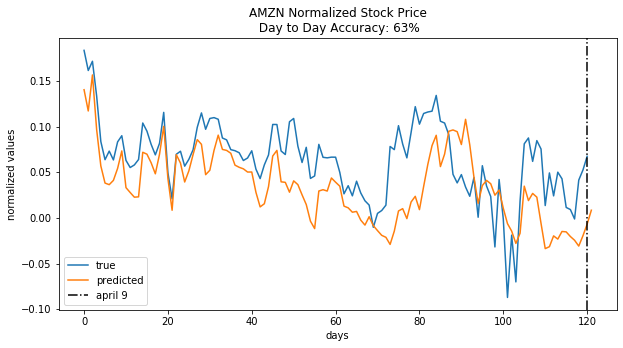

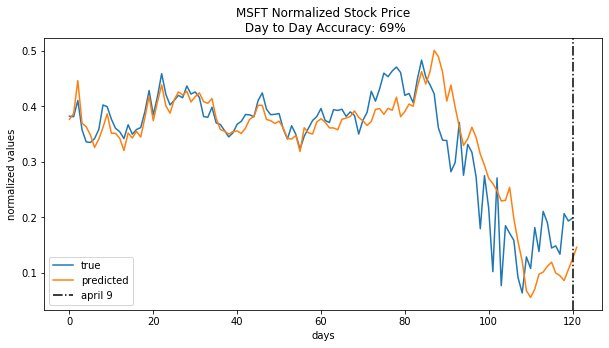

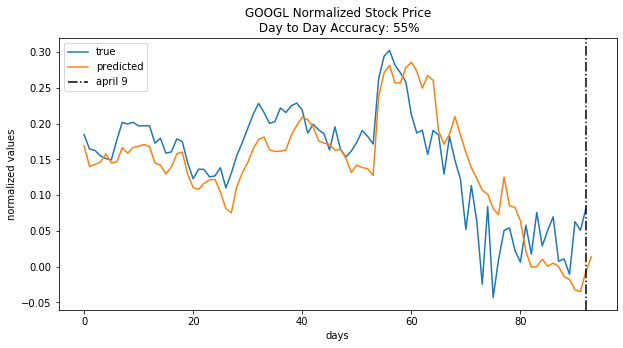

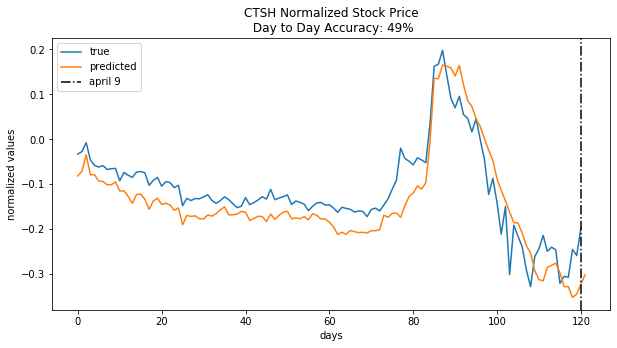

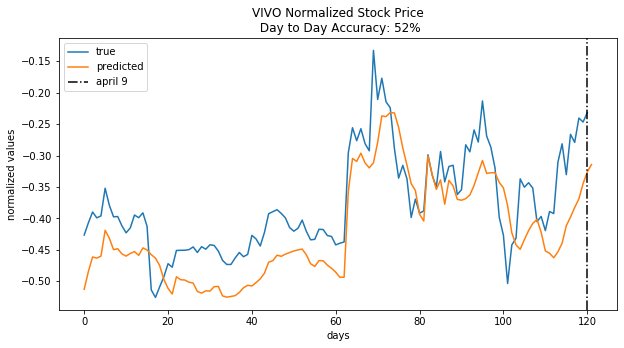

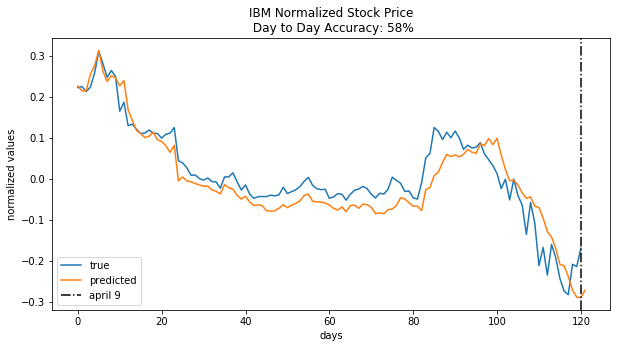

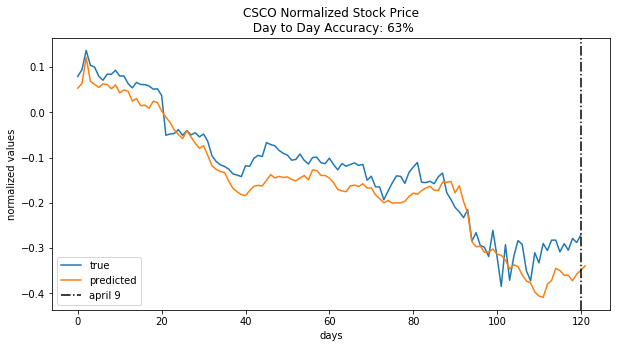

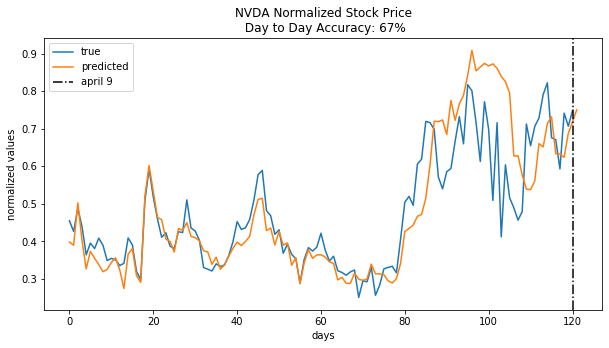

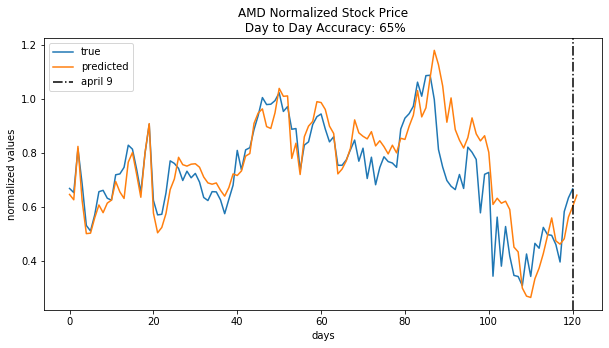

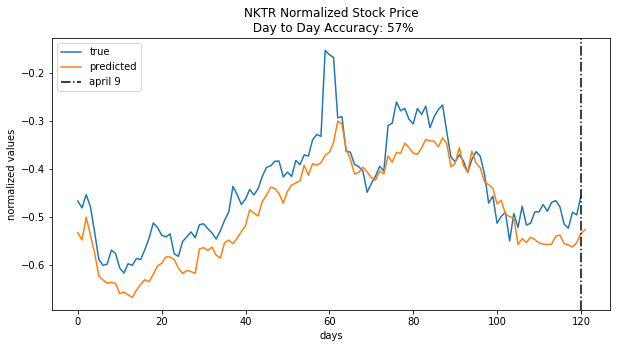

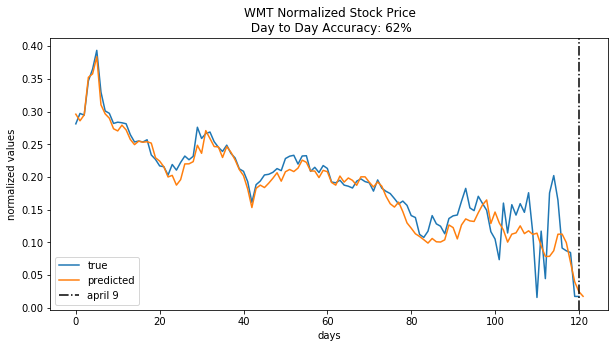

In [25]:
#10 works best
for stock in stock_list1:
    try:
        x_train,x_test,y_train,y_test, for_reverse, row = set_data(stock , seq_length)
        predicted = predict_point_by_point(model, x_test)        
        correct , incorrect = accuracy(y_test, predicted)
        new = []
        new = x_test[-1][1:]
        new = np.append(new, y_test[-1])
        new = new.reshape(1,-1,1)
        newPredicted = model.predict(new)
        predicted = np.append(predicted,newPredicted)
        shown_val = round(len(y_test) *.5)  
        stock_acc = round(float(correct/(correct+incorrect))*100) 
        plt.figure(figsize = (10,5))
        plt.plot(y_test[shown_val:], label = 'true')
        plt.plot(predicted[shown_val:], label = 'predicted')
        plt.axvline(len(y_test[shown_val:])-1, 0, 1, linestyle = '-.' , color ='black', label = 'april 9')
        plt.xlabel('days')
        plt.ylabel('normalized values')
        plt.title(stock + " Normalized Stock Price\n Day to Day Accuracy: " + str(stock_acc)+ "%")
        plt.legend()
        #plt.savefig("../1dayPredictions/" + stock +".png")
        plt.show()
        plt.clf()
        average = average + float(correct/(correct+incorrect))
        length = length + 1
        if float(correct/(correct+incorrect)) > best:
            best = float(correct/(correct+incorrect))
            best_stock = stock
            
    except:
        print("not found")
print("best stock:",best_stock)
print("score: ",best)
print("average: ", float(average/length))

In [23]:
stock_list1 = ['AMZN', 'MSFT', 'GOOGL', 'CTSH', 'VIVO', 'IBM', 'CSCO', 'NVDA','AMD', 'NKTR', 'WMT']

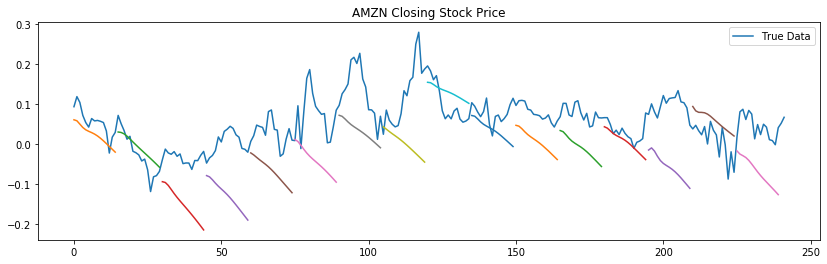

AMZN
number correct: 9
number incorrect 6
percetage correct: 0.6


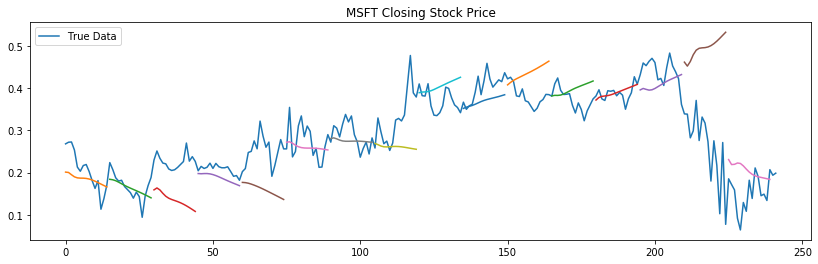

MSFT
number correct: 11
number incorrect 4
percetage correct: 0.7333333333333333


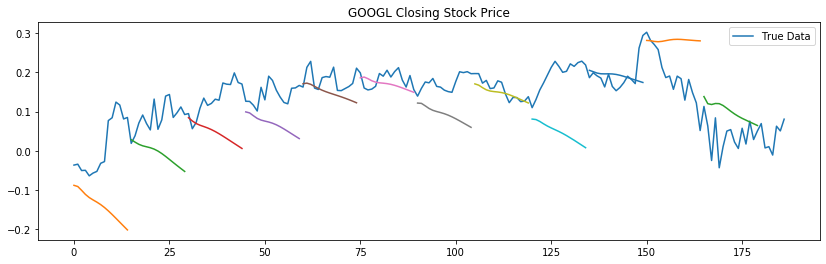

GOOGL
number correct: 4
number incorrect 7
percetage correct: 0.36363636363636365


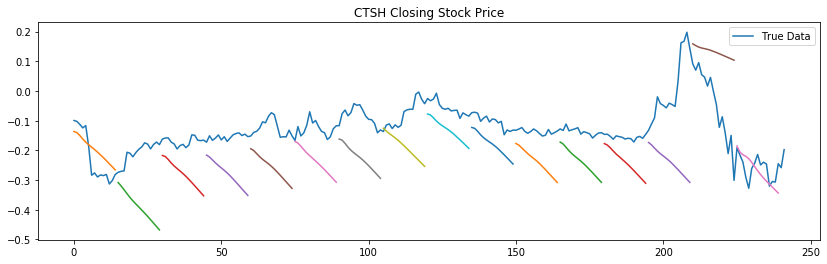

CTSH
number correct: 8
number incorrect 7
percetage correct: 0.5333333333333333


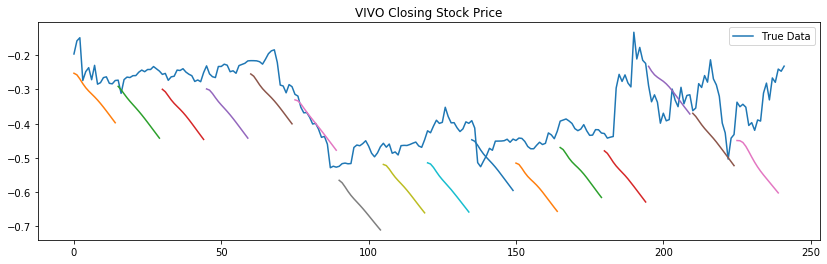

VIVO
number correct: 8
number incorrect 7
percetage correct: 0.5333333333333333


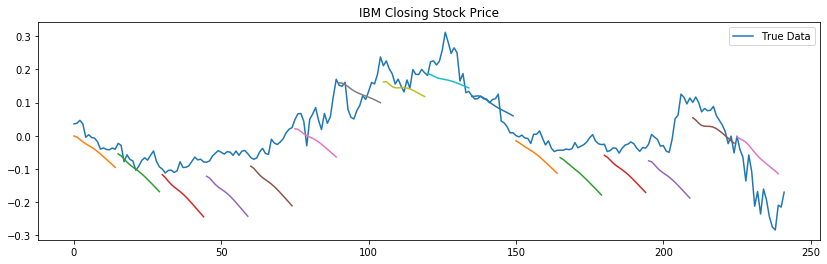

IBM
number correct: 8
number incorrect 7
percetage correct: 0.5333333333333333


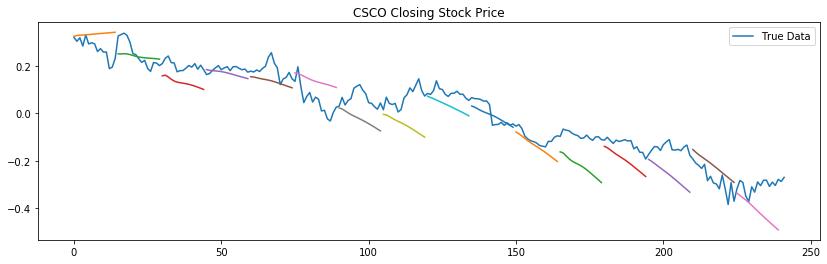

CSCO
number correct: 10
number incorrect 5
percetage correct: 0.6666666666666666


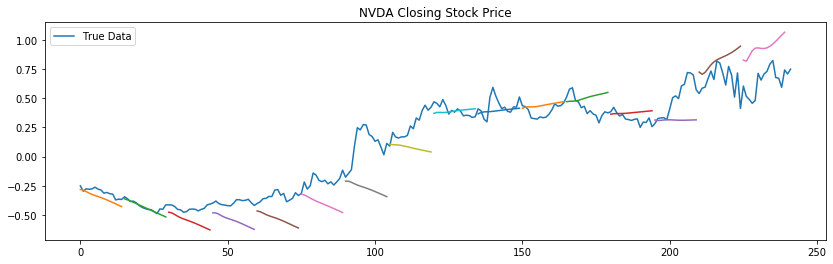

NVDA
number correct: 8
number incorrect 7
percetage correct: 0.5333333333333333


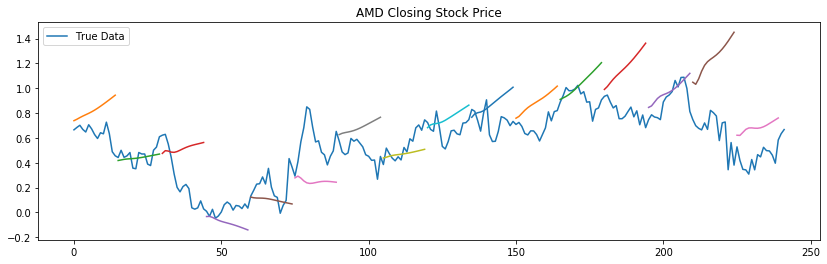

AMD
number correct: 6
number incorrect 9
percetage correct: 0.4


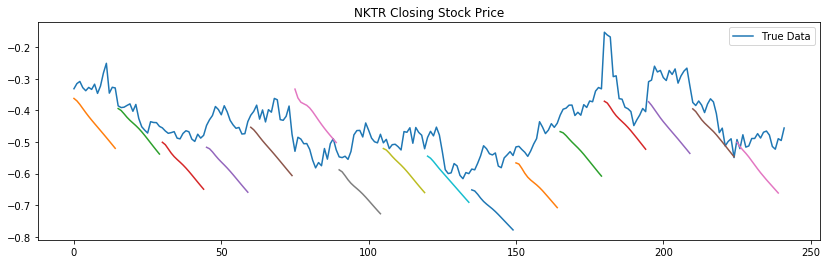

NKTR
number correct: 7
number incorrect 8
percetage correct: 0.4666666666666667


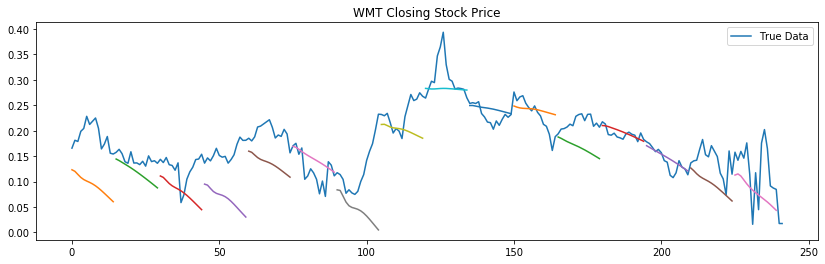

WMT
number correct: 11
number incorrect 4
percetage correct: 0.7333333333333333


In [26]:
for stock in stock_list1:
    x_train,x_test,y_train,y_test, result, row = set_data(stock , seq_length)
    predictions = predict_sequences_multiple(model, x_test, seq_length,15)
    plot_results_multiple(predictions, y_test, 15, stock) 
    correct , incorrect= n_day_accuracy(15, y_test, predictions)
    print(stock)
    print("number correct:", correct)
    print("number incorrect", incorrect)
    print("percetage correct:", float(correct/(correct+incorrect)))

In [16]:
model.save('stock_nn_'+ str(epochs)+'epochs_'+str(seq_length)+'best4.h5')

NameError: name 'model' is not defined

In [121]:
model = load_model('stock_nn_1epochs_200best4.h5')


In [93]:
def predict_future(days, model , x_test, y_test):
        prev_predicted = predict_point_by_point(model, x_test)
        new = x_test[-1][1:]
        new = np.append(new, y_test[-1])
        new = new.reshape(1,-1,1)
        newPredicted = model.predict(new)
        prev_predicted = np.append(prev_predicted,newPredicted)
        for i in range(2,days+1):
            new = x_test[-1][i:]
            new = np.append(new, prev_predicted[len(prev_predicted)-i:])
            new = new.reshape(1,-1,1)
            newPredicted = model.predict(new)
            prev_predicted = np.append(prev_predicted,newPredicted)
        return (y_test, prev_predicted)

In [94]:
days = 10

In [95]:
x_train, x_test, y_train,y_test, for_reverse, row = set_data('NVDA',seq_length)

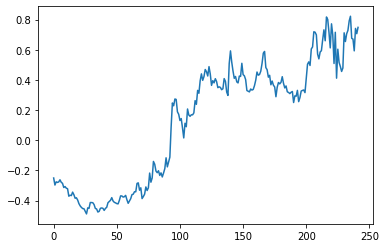

In [96]:
plt.plot(y_test)

In [99]:
x_train, x_test, y_train,y_test, for_reverse, row = set_data('NVDA',seq_length)
predictions = predict_sequences_multiple(model, x_test, seq_length,10)
correct , incorrect= n_day_accuracy(10, y_test, predictions)
stock_acc = round(float(correct/(correct+incorrect)*100))
y_test, predicted = predict_future(days, model, x_test, y_test)

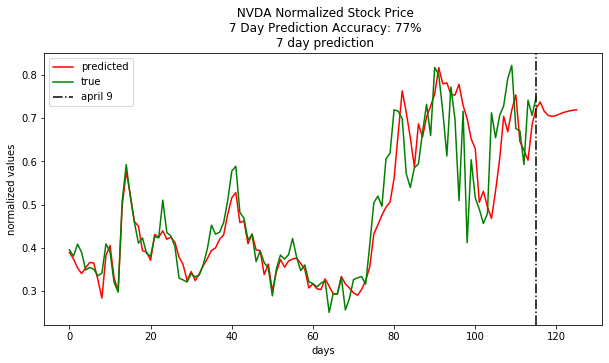

In [100]:
spot = round(len(predicted) * .5)
plt.figure(figsize = (10,5))
plt.plot(predicted[len(predicted)-spot:], color = 'red', label = 'predicted')
plt.plot(y_test[len(y_test)-spot+days:], color = 'g', label = 'true')
plt.xlabel('days')
plt.ylabel('normalized values')
plt.title(" NVDA Normalized Stock Price\n 7 Day Prediction Accuracy: " + str(stock_acc)+ "%\n 7 day prediction")
plt.axvline(spot-days-1, 0, 1, linestyle = '-.' , color ='black', label = 'april 9')
plt.legend()
plt.show()

In [ ]:
stock_list2 = set_stock_list()

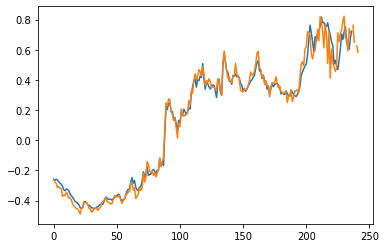

In [ ]:
for stock in stock_list2:
    try:
        if stock in stock_list:
            x_train, x_test, y_train,y_test, for_reverse, row = set_data(stock,seq_length)
            spot = round(len(y_test) * .5)
        else:
            x_train, x_test, y_train,y_test, for_reverse, row = set_data1(stock,seq_length)
            if len(y_test) > 500 :
                spot = 100
                x_test = x_test[round(len(x_test)*.7):]
            else:
                spot = round(len(y_test) * .6)
        #predictions = predict_sequences_multiple(model, x_test, seq_length,days)
        #correct , incorrect= n_day_accuracy(days, y_test, predictions)
        #stock_acc = round(float(correct/(correct+incorrect)*100))
        y_test, predicted = predict_future(days, model, x_test, y_test)
        plt.figure(figsize = (10,5))
        plt.plot(predicted[len(predicted)-spot:], color = 'red', label = 'predicted')
        plt.plot(y_test[len(y_test)-spot+days:], color = 'g', label = 'true')
        plt.xlabel('Days')
        plt.ylabel('Normalized Values')
        plt.title(stock + " Normalized Stock Price\n 10 Day Prediction")
        plt.axvline(spot-days-1, 0, 1, linestyle = '-.' , color ='black', label = 'april 9')
        plt.legend()
        plt.savefig("../next_n_days/" + stock +".png")
    except:
        print("not found")